# Dynamics with nearest neighbors interactions
[Index](../0-index.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import sys
import numpy as np
import cupy as cp
import pandas as pd
import h5py
import datetime
import scipy
import imageio

from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.colors as mco
import matplotlib.gridspec as mgs
import matplotlib.cm as cm
from matplotlib import animation
plt.rcParams['svg.fonttype'] = 'none'

from IPython.display import HTML
from IPython.display import Image

In [3]:
sys.path.append(str(Path('../..') / 'code'))
from functions import laplacian_discrete_conv, lattice_2d_integrate_sir

In [4]:
resdir = Path('../../results/')
if not resdir.is_dir():
    raise ValueError('No results directory!')

In [5]:
resfile = resdir / 'lattice_2d_nneighbors.hdf5'
complevel=7
complib='zlib'
if resfile.is_file():
    with h5py.File(resfile,'r') as f5py:
        f5py.visit(print)

beta_1.0e-01
beta_1.0e-01/n1_10_n2_0
beta_1.0e-01/n1_10_n2_0/infected
beta_1.0e-01/n1_10_n2_0/susceptible
beta_1.0e-01/n1_10_n2_0/times
beta_1.0e-01/n1_10_n2_1
beta_1.0e-01/n1_10_n2_1/infected
beta_1.0e-01/n1_10_n2_1/susceptible
beta_1.0e-01/n1_10_n2_1/times
beta_1.0e-01/n1_10_n2_2
beta_1.0e-01/n1_10_n2_2/infected
beta_1.0e-01/n1_10_n2_2/susceptible
beta_1.0e-01/n1_10_n2_2/times
beta_1.0e-01/n1_10_n2_4
beta_1.0e-01/n1_10_n2_4/infected
beta_1.0e-01/n1_10_n2_4/susceptible
beta_1.0e-01/n1_10_n2_4/times
beta_1.0e-01/n1_10_n2_6
beta_1.0e-01/n1_10_n2_6/infected
beta_1.0e-01/n1_10_n2_6/susceptible
beta_1.0e-01/n1_10_n2_6/times
beta_1.0e-01/n1_10_n2_8
beta_1.0e-01/n1_10_n2_8/infected
beta_1.0e-01/n1_10_n2_8/susceptible
beta_1.0e-01/n1_10_n2_8/times
n1_10_n2_0
n1_10_n2_0/beta_1.0e-01
n1_10_n2_0/beta_1.0e-01/infected
n1_10_n2_0/beta_1.0e-01/susceptible
n1_10_n2_0/beta_1.0e-01/times
n1_10_n2_0/beta_2.0e-01
n1_10_n2_0/beta_2.0e-01/infected
n1_10_n2_0/beta_2.0e-01/susceptible
n1_10_n2_0/beta_2.0e-0

## Parameters

In [6]:
n1 = 10 # 2^n1 is the length
n2 = 0 # 2^n2 is the height
Delta_x = 1
alpha = 1.0e-1  # intra-community infectivity coefficient
beta = alpha   # extra-community infectivity coefficient
gamma = 0.1 # inverse recovery time

tmax = 3000. # maximum time
tdump = 1.0e0  # time interval between dumps

params = { \
          'delta_x': Delta_x, \
          'alpha': alpha, \
          'beta': beta, \
          'gamma': gamma, \
          'n1': n1, \
          'n2': n2, \
          'tmax': tmax, \
          'tdump': tdump
}
params_template = {key: params[key] for key in params.keys()}
pref = "beta_{:.1e}".format(beta)

cp.cuda.Device(0).use()
exts = ['.png', '.svg']

In [7]:
n2_list = [0, 1, 2, 4, 6, 8]
n_list = len(n2_list)

In [8]:
for n2 in n2_list:
    print("".join(['-']*10))
    print("n2 = {:.1e}".format(n2))
    params = {key:params_template[key] for key in params_template.keys()}
    params['n2'] = n2
    
    # initial condition
    eps = 1.0e-8    # total fraction of population
    N = 2**(n1+n2)  # total number of communities

    S = cp.ones((2**n1, 2**n2), dtype=np.float_)
    I = cp.zeros((2**n1, 2**n2), dtype=np.float_)

    if n2 == 0:
        V = cp.array([N*eps])
    else:
        V = cp.zeros(2**n2)
        V[[2**(n2-1)-1,2**(n2-1)]] = 0.5*N*eps
    S[0] -= V
    I[0] += V

    times, Ss, Is = lattice_2d_integrate_sir(S, I, alpha=alpha, beta=beta, gamma=gamma, tmax=tmax, tdump=tdump, method='DOP853')
    print("integration complete")

    # save
    path = str(Path(pref) / "n1_{:d}_n2_{:d}".format(n1,n2))
    with h5py.File(resfile,'a') as f5py:
        if not (path in f5py.keys()):
            grp = f5py.create_group(path)
        grp = f5py[path]
        for key in params.keys():
            grp.attrs[key] = params[key]

    #     print(grp.keys())
        name = "times"
        if name in grp.keys():
            del grp[name]
        dset = grp.create_dataset(name, shape=times.shape, dtype=times.dtype, data=times, \
                          compression="gzip", compression_opts=complevel)

        name = "susceptible"
        if name in grp.keys():
            del grp[name]
        dset = grp.create_dataset(name, shape=Ss.shape, dtype=Ss.dtype, data=Ss, \
                          compression="gzip", compression_opts=complevel)

        name = "infected"
        if name in grp.keys():
            del grp[name]
        dset = grp.create_dataset(name, shape=Is.shape, dtype=Is.dtype, data=Is, \
                          compression="gzip", compression_opts=complevel)
    print("data written to {:s}>{:s}".format(str(resfile), path))

----------
n2 = 0.0e+00
integration complete
data written to ../../results/lattice_2d_nneighbors.hdf5>beta_1.0e-01/n1_10_n2_0
----------
n2 = 1.0e+00
integration complete
data written to ../../results/lattice_2d_nneighbors.hdf5>beta_1.0e-01/n1_10_n2_1
----------
n2 = 2.0e+00
integration complete
data written to ../../results/lattice_2d_nneighbors.hdf5>beta_1.0e-01/n1_10_n2_2
----------
n2 = 4.0e+00
integration complete
data written to ../../results/lattice_2d_nneighbors.hdf5>beta_1.0e-01/n1_10_n2_4
----------
n2 = 6.0e+00
integration complete
data written to ../../results/lattice_2d_nneighbors.hdf5>beta_1.0e-01/n1_10_n2_6
----------
n2 = 8.0e+00
integration complete
data written to ../../results/lattice_2d_nneighbors.hdf5>beta_1.0e-01/n1_10_n2_8


In [9]:
times_list = []
I_tot_list = []
T_tot_list = []
dT_tot_list = []
Sm_list = []
Im_list = []
Tm_list = []
dTm_list = []

for n2 in n2_list:
    path = str(Path(pref) / "n1_{:d}_n2_{:d}".format(n1,n2))
    with h5py.File(resfile,'r') as f5py:
        if not (path in f5py.keys()):
            raise ValueError("{:s} not in the database".format(path))
        grp = f5py[path]

    #     print(grp.keys())
        name = "times"
        times = grp[name][:]

        name = "susceptible"
        Ss = grp[name][:]

        name = "infected"
        Is = grp[name][:]

    dt = np.diff(times)[0]
    Ts = 1 - Ss
    dTs = np.concatenate([Is[0].reshape(1,Is.shape[1], Is.shape[2]), np.diff(Ts, axis=0)], axis=0)
    dTs /= dt

    dT_tot = np.mean(dTs, axis=(1,2))
    T_tot = np.mean(Ts, axis=(1,2))
    I_tot = np.mean(Is, axis=(1,2))

    if n2 == 0:
        midline = [0]
    else:
        midline = [2**(n2-1)-1,2**(n2-1)]
    Sm = np.mean(Ss[:,:,midline], axis=2)
    Im = np.mean(Is[:,:,midline], axis=2)
    Tm = np.mean(Ts[:,:,midline], axis=2)
    dTm = np.mean(dTs[:,:,midline], axis=2)
    
    times_list.append(times)
    I_tot_list.append(I_tot)
    T_tot_list.append(T_tot)
    dT_tot_list.append(dT_tot)
    Sm_list.append(Sm)
    Im_list.append(Im)
    dTm_list.append(dTm)
    Tm_list.append(Tm)

## Figures

In [10]:
figdir = Path('..') / '..' / 'figures' / '6-simulations' / '64-lattice_2d_nneighbors_loop_n2'
if not figdir.is_dir():
    figdir.mkdir(parents=True, exist_ok=True)
print(figdir)

../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2


### Total number of new cases

In [11]:
# parameters
figsize = (6,4.5)
dpi = 300
ms=2
lw=1
show_dT=False

norm = mco.Normalize(vmin=0, vmax=n_list-1)
cmap = cm.rainbow

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

if show_dT:
    for n in range(n_list):
        n2 = n2_list[n]
        times = times_list[n]
        dT_tot = dT_tot_list[n]
        label = "n2 = {:d}".format(n2)

        ax.plot(times,dT_tot, '-', ms=ms, color=cmap(norm(n)), label=label)
        ax.set_ylabel("$d T$", fontsize="medium")
    fname = 'domega_tot'
else:
    for n in range(n_list):
        n2 = n2_list[n]
        times = times_list[n]
        T_tot = T_tot_list[n]
        label = "n2 = {:d}".format(n2)

        ax.plot(times,T_tot, '-', ms=ms, color=cmap(norm(n)), label=label)
        ax.set_ylabel("$T$", fontsize="medium")
    fname = 'omega_tot'

ax.legend(loc='best', fontsize='medium')
ax.set_xlim(times[0],None)
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/omega_tot.png
Written file: ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/omega_tot.svg


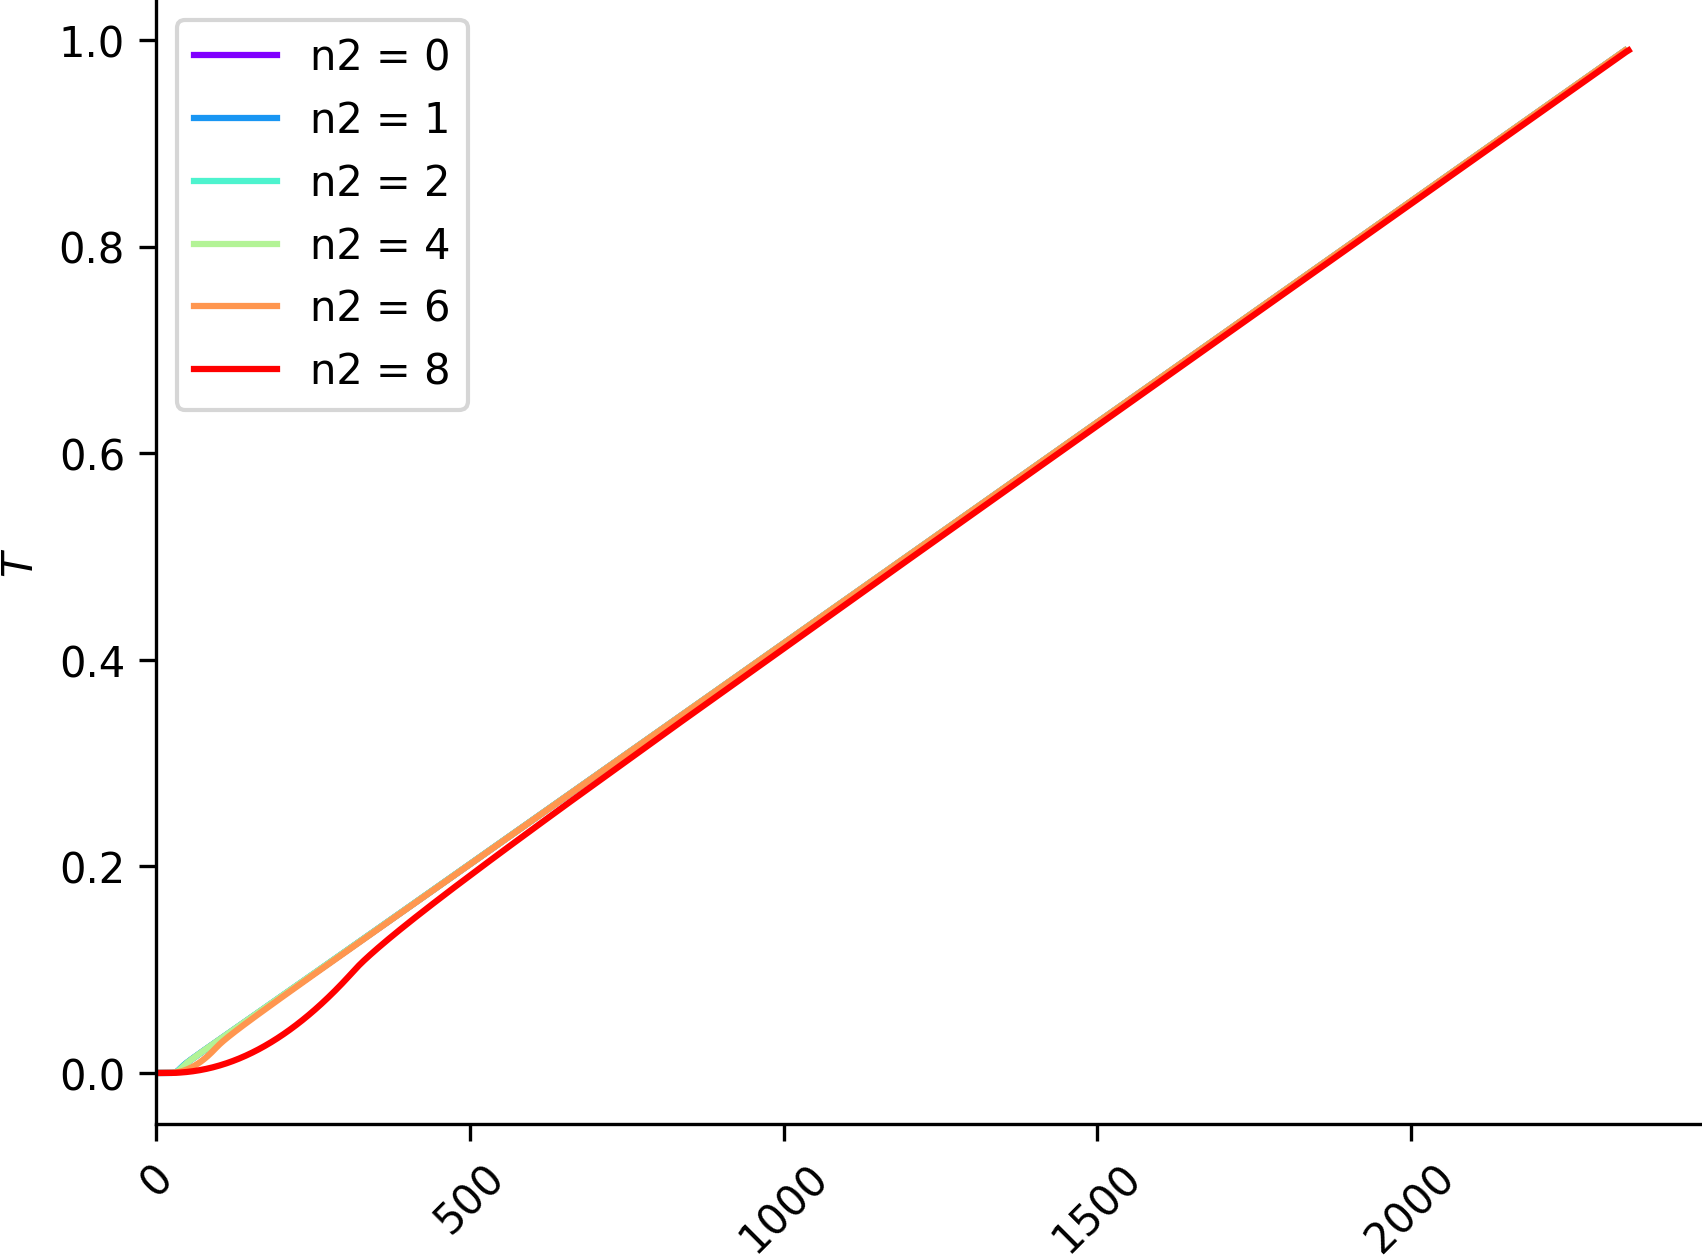

In [12]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

### Wave position

In [13]:
from functions import lattice_2d_ramp_fit as ramp_fit
from functions import lattice_2d_get_velocity_theoretical as get_velocity_theoretical
from functions import framp

In [14]:
# parameters
figsize = (6,4.5)
dpi = 300
ms=2
lw=1

pfit_list = []
# make figure
fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

for n in range(n_list):
    n2 = n2_list[n]
    times = times_list[n]
    dTm = dTm_list[n]
    W = np.argmax(dTm, axis=1)
    
    color = cmap(norm(n))
    label = "n2 = {:d}".format(n2)
    
    ax.plot(times, W, '-', color=color, lw=lw, ms=ms, label=label)
    
    pfit = ramp_fit(W, times, wmax=0.2*np.max(W), maxfev=1000)
    pfit_list.append(pfit)
    
    plt.plot(times, framp(times, *pfit), 'k--', lw=lw)
    
    v = get_velocity_theoretical(beta, gamma, beta, S_ss=1.)
    plt.plot(times, v*(times-pfit[1]), 'k-.', lw)
    

ax.set_xlim(times[0],None)
ax.set_ylim(0., None)
ax.set_xlabel("time", fontsize="medium")
ax.set_ylabel("column", fontsize="medium")
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

fname = 'wave_position'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/wave_position.png
Written file: ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/wave_position.svg


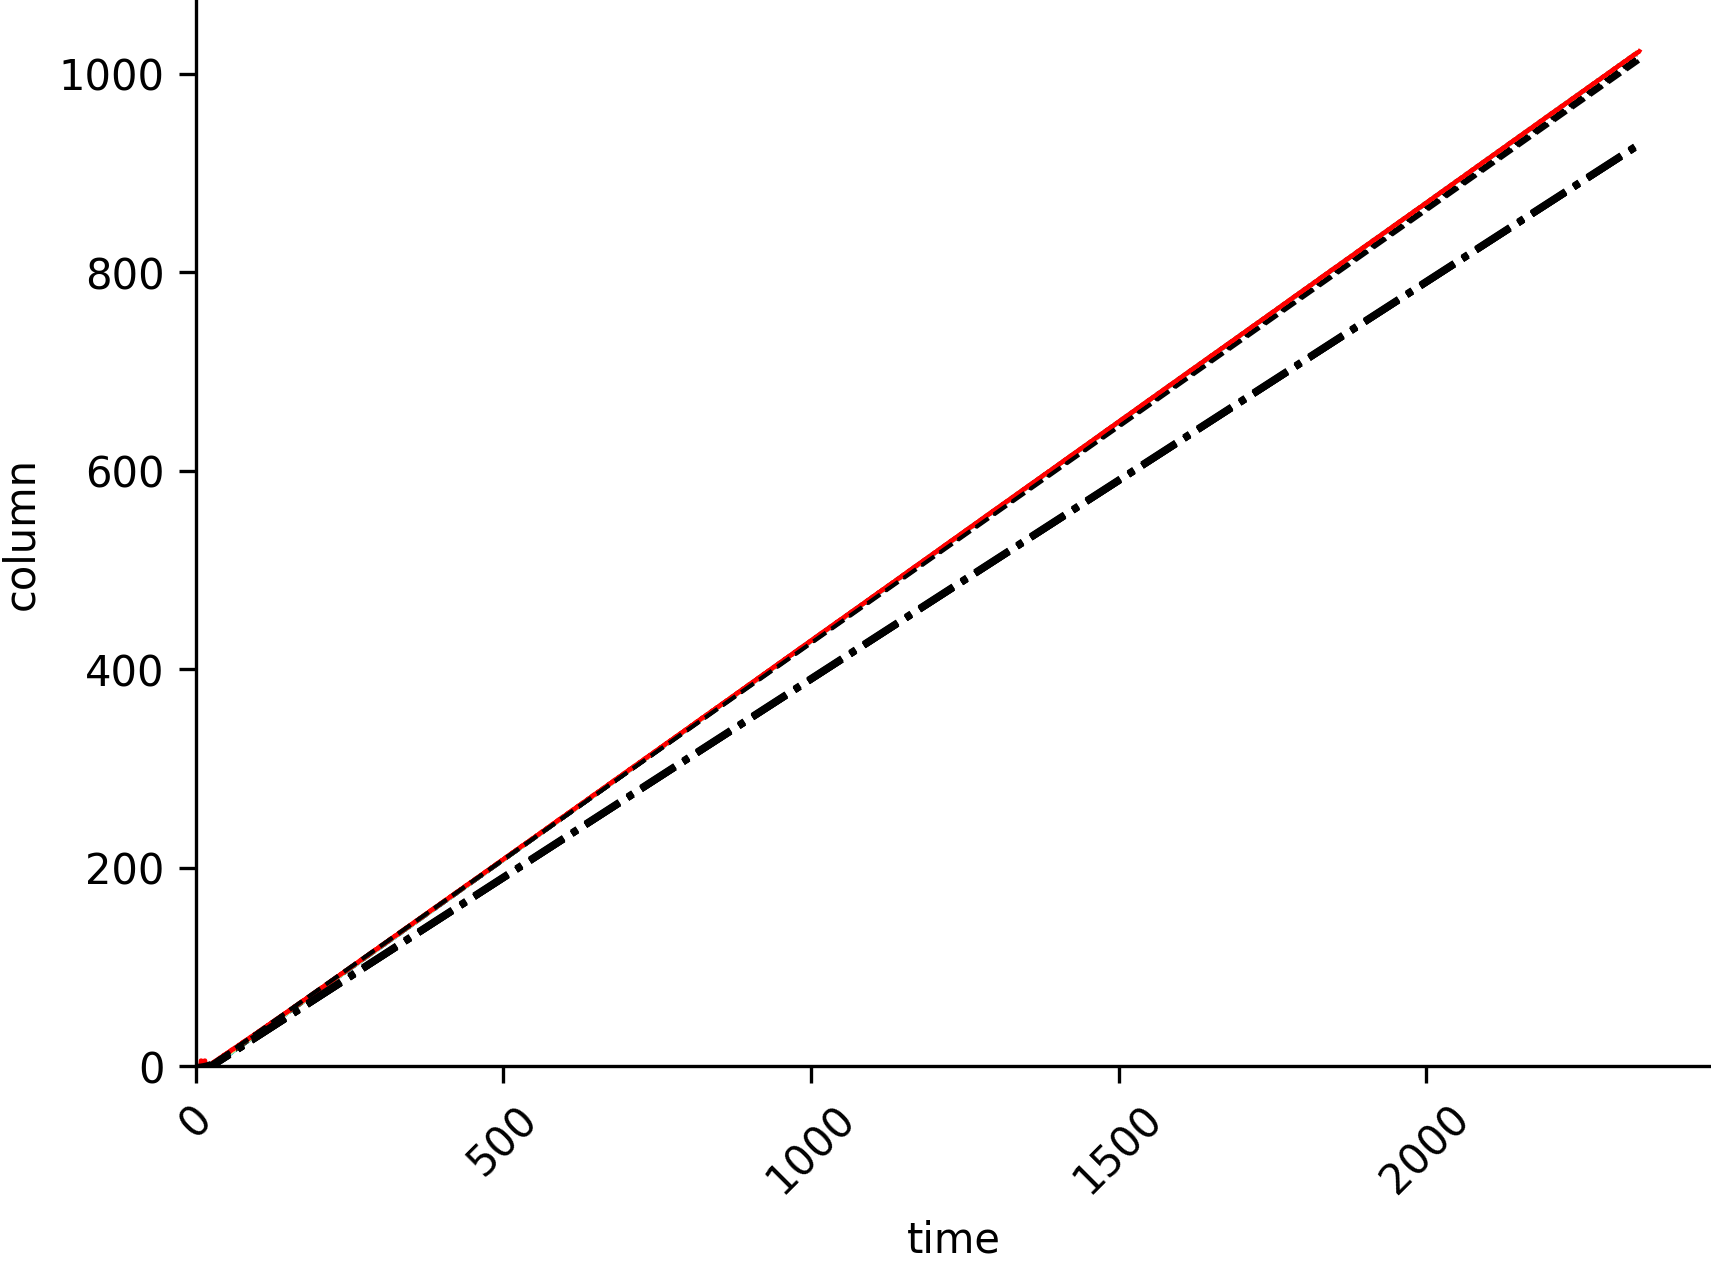

In [15]:
fname = 'wave_position'
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

### Fit to analytical prediction

In [16]:
from functions import wave_front_get_ode_sol, get_binned
from scipy.optimize import minimize_scalar, bracket

In [17]:
from functions import lattice_2d_get_velocity as get_velocity
from functions import lattice_2d_rescale_wave_profile as rescale_wave_profile

In [18]:
figsize=(8,4.5)
fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()
kfit_list = []
dx = params['delta_x']
X = np.arange(2**n1, dtype=np.float_)

for n in range(n_list):
# for n in range(2):
    n2 = n2_list[n]
    alpha = beta
    times = times_list[n]
    dTm = dTm_list[n]
    W = np.argmax(dTm, axis=1)
    
    color = cmap(norm(n))
    label = "n2 = {:d}".format(n2)
    
    v = get_velocity(W, times, wmax=0.2*np.max(W), maxfev=1000)
    
    a = alpha/beta + 4.
    C = a*beta**2/(4*v**2)
    D = 2*gamma/(beta*a)
    CMAX = 1./(16*(1-0.5*D))
    print("v = {:.4f}    C = {:.4f}    D = {:.4f}    CMAX = {:.4f}".format(v,C,D,CMAX))
    
    # theoretical value for scale k
    kfit = 2*v/beta 

    # compute profile (centered around its maximum)
    Z_C, Y_C, S_C, R_C = wave_front_get_ode_sol(C, D, tmax=10000, npts=100000, eps=1.0e-3)
    k0 = np.argmax(Y_C)
    Z_C -= Z_C[k0]

    # fit the wave profile at a given time
    kt = int(0.9*len(times))
    Z, Y = rescale_wave_profile(kfit, X, dTm[kt], Z_C, Y_C, v, dx)
    
    # plots
    ax.plot(Z_C, Y_C, '-', color=color, lw=lw)
    ax.plot(Z, Y, 's', color=color, ms=2*ms, label="n2 = {:d}, C = {:.4f}".format(n2, C))
#     ax.plot(Z, G/(v*kfit/2.), 's', color=color, ms=2*ms, label="beta = {:.1e}, C = {:.4f}".format(beta, C))
    
ax.set_xlim(-100,100)
# ax.set_ylim(0., 1)
ax.legend(loc='upper left', fontsize='medium', bbox_to_anchor=(1., 0.98), frameon=False)
ax.set_xlabel("date", fontsize="medium")
ax.set_ylabel("column", fontsize="medium")
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

fname = 'profile_collapse_fit'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

v = 0.4391    C = 0.0648    D = 0.4000    CMAX = 0.0781
v = 0.4391    C = 0.0648    D = 0.4000    CMAX = 0.0781
v = 0.4392    C = 0.0648    D = 0.4000    CMAX = 0.0781
v = 0.4384    C = 0.0650    D = 0.4000    CMAX = 0.0781
v = 0.4369    C = 0.0655    D = 0.4000    CMAX = 0.0781
v = 0.4359    C = 0.0658    D = 0.4000    CMAX = 0.0781
Written file: ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/profile_collapse_fit.png
Written file: ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/profile_collapse_fit.svg


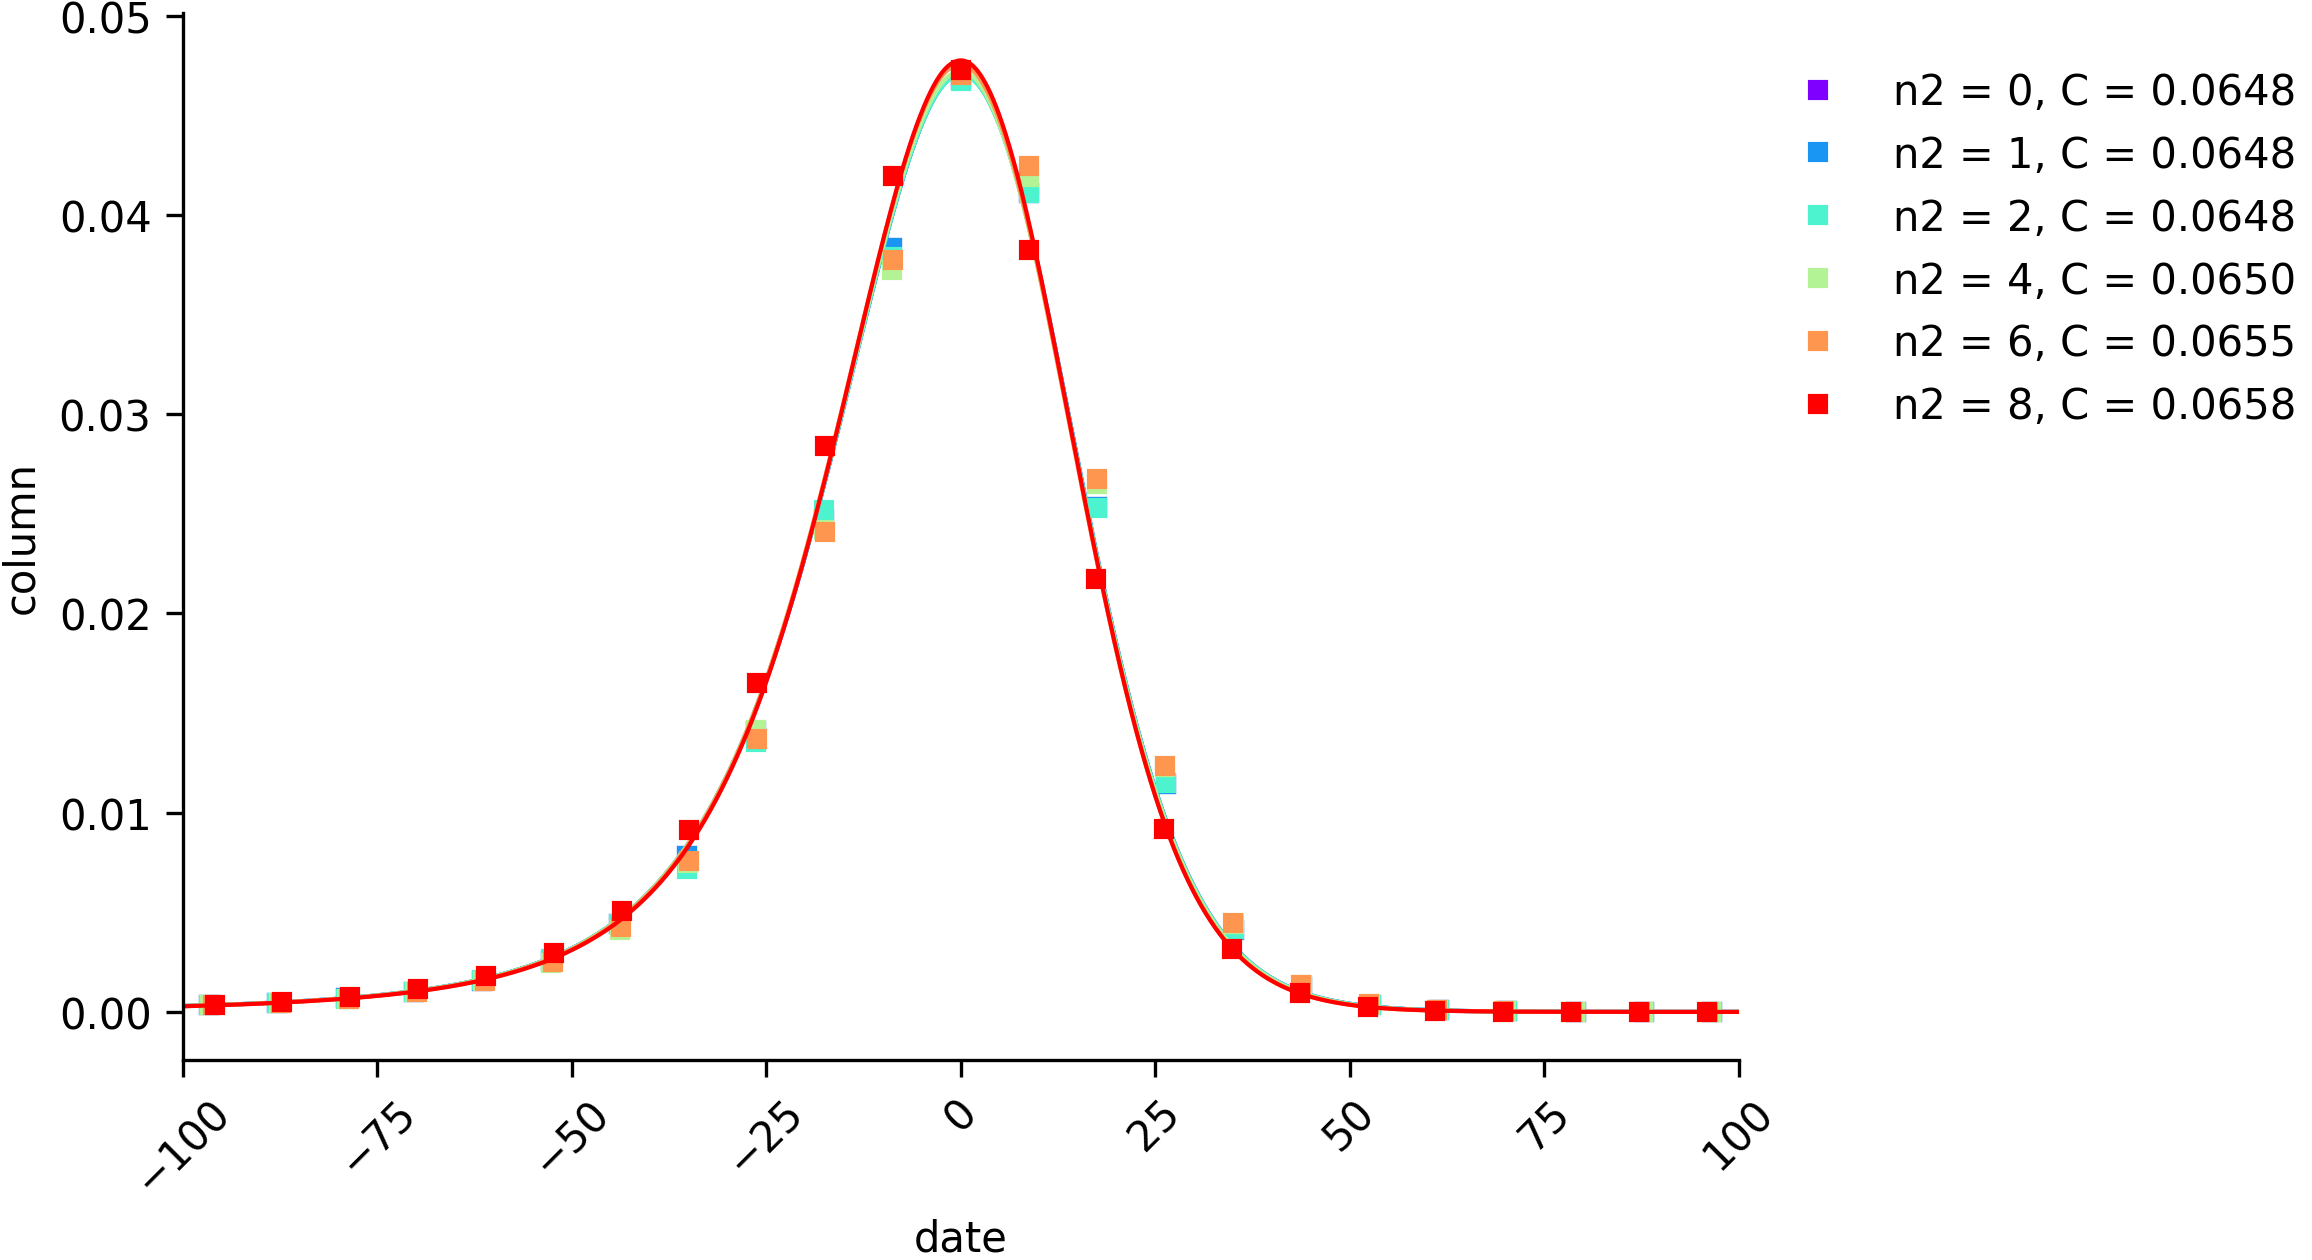

In [19]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

## Show wave profiles

In [20]:
time_sel = np.linspace(0., 200, 21).astype('int64')

for n in range(len(n2_list)):
    n2 = n2_list[n]
    print("n2 = ¨{:d}".format(n2))
    times = times_list[n]
    dTm = dTm_list[n]

    norm = mco.Normalize(0, len(time_sel)-1)
    cmap = cm.viridis

    figsize=(12,3)
    fig = plt.figure(facecolor='w', figsize=figsize)
    ax = fig.gca()

    X = np.arange(2**n1, dtype=np.float_)

    for k in range(len(time_sel)):
        t = time_sel[k]
        color = cmap(norm(k))

        Y = dTm[t]
        idx = Y > 0.
        ax.plot(X[idx], Y[idx], '-', color=color, lw=lw)


    # ax.legend(loc='best')
    ax.set_xlim(0,None)
    ax.set_ylim(0., None)
    ax.set_xlabel("x", fontsize="medium")
    ax.set_ylabel("dT", fontsize="medium")
    plt.xticks(rotation=45)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
    ax.tick_params(axis='both', length=4)
    fig.tight_layout(rect=[0., 0., 0.98, 1.])

    cax = fig.add_axes(rect=[0.98,0.2,0.01,0.7])
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                 cax=cax, extendfrac='auto')

    cbar.set_label("time")

    fname = 'wave_profiles_n2_{:d}'.format(n2)
    for ext in exts:
        filepath = figdir / (fname + ext)
        fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
        print("Written file: {:s}".format(str(filepath)))
    fig.clf()
    plt.close('all')

n2 = ¨0
Written file: ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/wave_profiles_n2_0.png
Written file: ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/wave_profiles_n2_0.svg
n2 = ¨1
Written file: ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/wave_profiles_n2_1.png
Written file: ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/wave_profiles_n2_1.svg
n2 = ¨2
Written file: ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/wave_profiles_n2_2.png
Written file: ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/wave_profiles_n2_2.svg
n2 = ¨4
Written file: ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/wave_profiles_n2_4.png
Written file: ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/wave_profiles_n2_4.svg
n2 = ¨6
Written file: ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/wave_profiles_n2_6.png
Written file: ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/wav

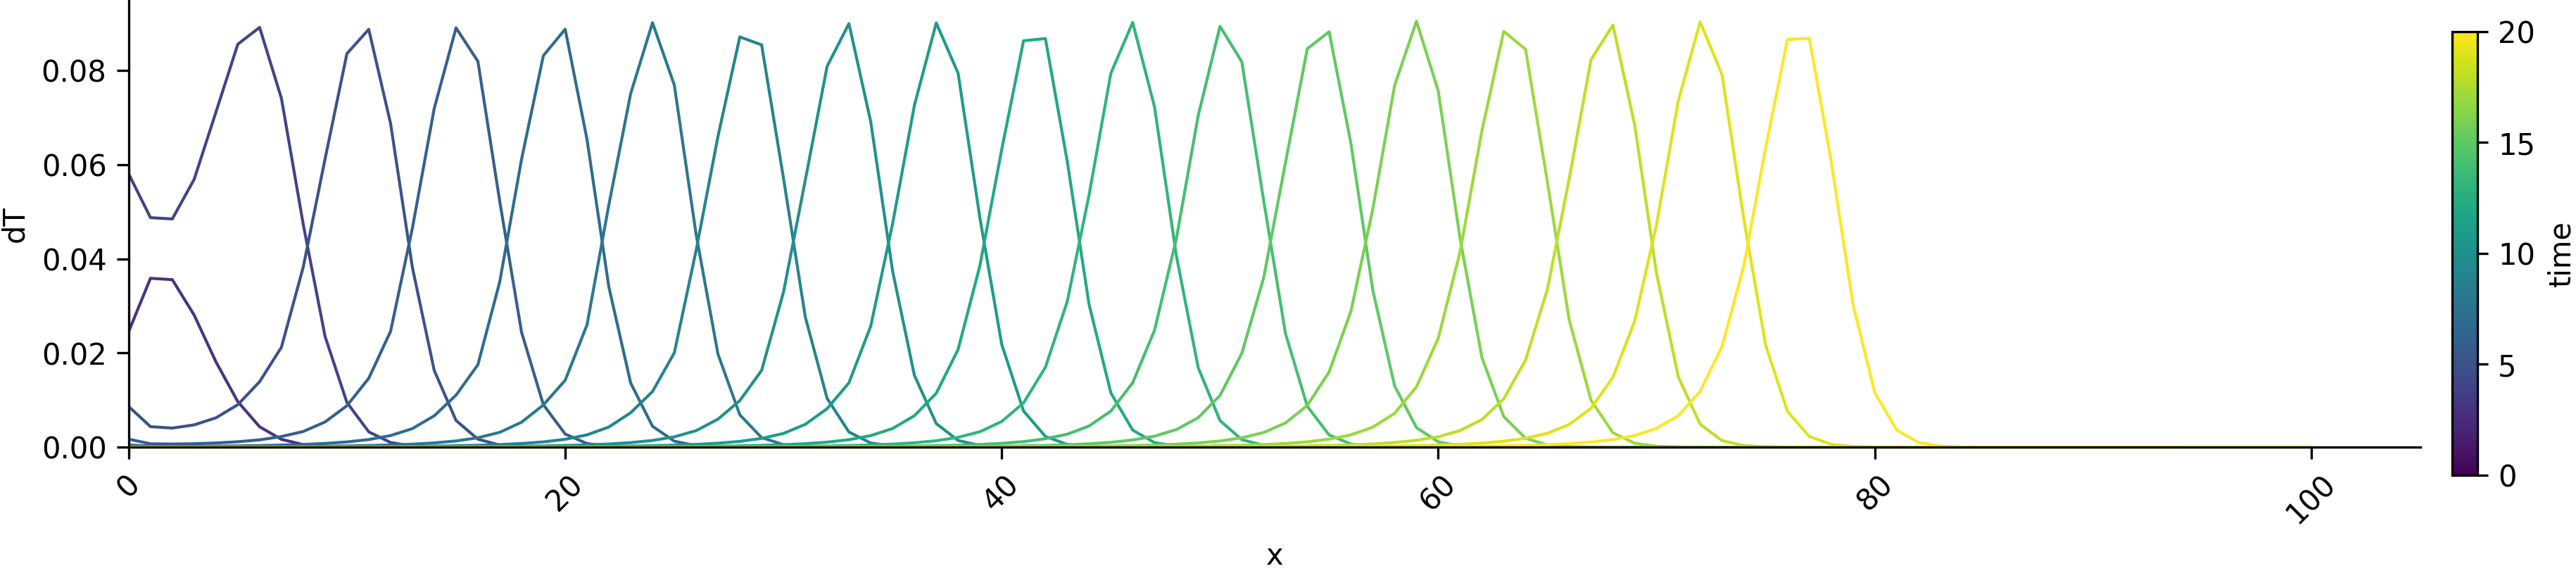

In [21]:
n2 = 0
fname = 'wave_profiles_n2_{:d}'.format(n2)
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*480)

## Wave animation

In [22]:
fps = 30
dpi=300
outputdir = figdir / '2d_plots'
idump = max(int(tmax/tdump/1000),1)

for n in range(len(n2_list)):
    n2 = n2_list[n]
    print("n2 = ¨{:d}".format(n2))

    path = str(Path(pref) / "n1_{:d}_n2_{:d}".format(n1,n2))
    with h5py.File(resfile,'r') as f5py:
        if not (path in f5py.keys()):
            raise ValueError("{:s} not in the database".format(path))
        grp = f5py[path]

    #     print(grp.keys())
        name = "times"
        times = grp[name][::idump]

        name = "susceptible"
        Ss = grp[name][::idump]

        name = "infected"
        Is = grp[name][::idump]
    dt = np.diff(times)[0]
    Ts = 1 - Ss
    dTs = np.concatenate([Is[0].reshape(1,Is.shape[1], Is.shape[2]), np.diff(Ts, axis=0)], axis=0)
    dTs /= dt

    tpdir = outputdir / 'n2_{:d}'.format(n2)
    if not tpdir.is_dir():
        tpdir.mkdir(parents=True, exist_ok=True)
    for ext in exts:
        for f in tpdir.glob('*' + ext): f.unlink()

    fileout = outputdir / 'n2_{:d}.mp4'.format(n2)
    tfmt = "t{:0" + "{:.0f}".format(np.ceil(np.log10(times[-1]))) + ".{:.0f}".format(max(0,-int(np.floor(np.log10(np.diff(times)[0]))))) +"f}"

    nt = len(times)
    vmax = 10**np.ceil(np.log10(np.max(dTs)))
    filenames = []
    for kt in range(nt):
        t = times[kt]
        fig = plt.figure(dpi=dpi)
        ax = fig.gca()

        title = "t = {:.1f}".format(t)
        ax.set_title(title, fontsize="large")
        im = ax.imshow(dTs[kt].T, cmap=cm.magma_r, origin='lower', vmin=0., vmax=vmax)
        ax.tick_params(axis='both', length=4)
        plt.colorbar(im, label='dT')

        fname = str(tpdir / tfmt.format(t))
        for ext in ['.png']:
            fpath = fname + ext
            fig.savefig(fpath, dpi=dpi, bbox_inches='tight', pad_inches=0)
        fpath = fname + ".png"
        filenames.append(fpath)
        fig.clf()
        plt.close('all')

    # write movie
    imageio.mimsave(fileout, [imageio.imread(f) for f in filenames], fps=fps)
    print(f"Written file {fileout}.")
    # shutil.rmtree(tpdir)

n2 = ¨0


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1544, 947) to (1552, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/2d_plots/n2_0.mp4.
n2 = ¨1


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1469, 947) to (1472, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/2d_plots/n2_1.mp4.
n2 = ¨2


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1509, 947) to (1520, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/2d_plots/n2_2.mp4.
n2 = ¨4


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1496, 947) to (1504, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/2d_plots/n2_4.mp4.
n2 = ¨6


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1496, 947) to (1504, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/2d_plots/n2_6.mp4.
n2 = ¨8


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1522, 947) to (1536, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../../figures/6-simulations/64-lattice_2d_nneighbors_loop_n2/2d_plots/n2_8.mp4.


In [23]:
k=5
fpath = outputdir / 'n2_{:d}.mp4'.format(n2_list[k])
HTML("""
<video height="360" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fpath)))